This is my copy of someone elses notebook where I've fixed a few things so that more of the code runs. This demonstrates how the network dissection method works when applied to image generation and classification networks.

In [ ]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
pip install ninja 2>> install.log
git clone https://github.com/SIDN-IAP/global-model-repr.git tutorial_code 2>> install.log

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
try: # set up path
    import google.colab, sys, torch
    sys.path.append('/content/tutorial_code')
    if not torch.cuda.is_available():
        print("Change runtime type to include a GPU.")
except:
    pass


Change runtime type to include a GPU.


# GAN Dissection

Our mission: look inside a GAN generator to see what it does.

We begin with some imports and jupyter setup.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running pytorch', torch.__version__, 'using', device.type)

Running pytorch 1.12.1+cu113 using cpu


## Instantiating a pretrained GAN generator.

We're going to use a progressive GAN.

Below I download and instantiate a model for outdoor churches.

You can uncomment the model of your choice.

After we create the model, I just print out all the layers.

In [ ]:
import torchvision
import torch.hub
from netdissect import nethook, proggan

# n = 'proggan_bedroom-d8a89ff1.pth'
n = 'proggan_churchoutdoor-7e701dd5.pth'
# n = 'proggan_conferenceroom-21e85882.pth'
# n = 'proggan_diningroom-3aa0ab80.pth'
# n = 'proggan_kitchen-67f1e16c.pth'
# n = 'proggan_livingroom-5ef336dd.pth'
# n = 'proggan_restaurant-b8578299.pth'

url = 'http://gandissect.csail.mit.edu/models/' + n
try:
    sd = torch.hub.load_state_dict_from_url(url) # pytorch 1.1
except:
    sd = torch.hub.model_zoo.load_url(url) # pytorch 1.0
model = proggan.from_state_dict(sd).to(device)
model

Downloading: "http://gandissect.csail.mit.edu/models/proggan_churchoutdoor-7e701dd5.pth" to /root/.cache/torch/hub/checkpoints/proggan_churchoutdoor-7e701dd5.pth


  0%|          | 0.00/70.0M [00:00<?, ?B/s]

ProgressiveGenerator(
  (layer1): NormConvBlock(
    (norm): PixelNormLayer()
    (conv): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3), bias=False)
    (wscale): WScaleLayer()
    (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer2): NormConvBlock(
    (norm): PixelNormLayer()
    (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (wscale): WScaleLayer()
    (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer3): NormUpscaleConvBlock(
    (norm): PixelNormLayer()
    (up): DoubleResolutionLayer()
    (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (wscale): WScaleLayer()
    (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer4): NormConvBlock(
    (norm): PixelNormLayer()
    (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (wscale): WScaleLayer()
    (relu): LeakyReLU(negative_slope=0.2, inplace=Tru

# Exercise 1 - Directly inspect the internal representation

In this exercise we just run the code provided and scrutinize the activations directly.

## Running the model.

The GAN generator is just a function z->x that transforms random z to realistic images x.

To generate images, all we need is a source of random z.  Let's make a micro dataset with a few random z.

In [ ]:
from netdissect import zdataset

SAMPLE_SIZE = 50 # Increase this for better results
zds = zdataset.z_dataset_for_model(model, size=SAMPLE_SIZE, seed=5555)
len(zds), zds[0][0].shape

(50, torch.Size([512, 1, 1]))

We can just invoke model(z[None,...]) to generate a single image.

In [ ]:
# Look at the output data - print a few pixel values
model(zds[0][0][None,...].to(device)).shape

torch.Size([1, 3, 256, 256])

## Visualizing the output.

The netdissect toolkit comes with a few simple visualization tools for examining images in notebooks.

  * renormalize turns tensors that were normalized as [-1...1] back into PIL images.
  * show takes nested arrays of images and text and lays then out as grids and tables.
  
Let's look at the images we created with our model.

In [ ]:
from netdissect import renormalize, show
# from IPython.display import display

show([
    [renormalize.as_image(model(z[None,...].to(device))[0])]
    for [z] in zds
])


## Hooking a model with InstrumentedModel

To analyze what a model is doing inside, we can wrap it with an InstrumentedModel, which makes it easy to hook or modify a particular layer.

InstrumentedModel adds a few useful functions for inspecting a model, including:
   * `model.retain_layer('layername')` - hooks a layer to hold on to its output after computation
   * `model.retained_layer('layername')` - returns the retained data from the last computation
   * `model.edit_layer('layername', rule=...)` - runs the `rule` function after the given layer
   * `model.remove_edits()` - removes editing rules

Let's setup `retain_layer` now.  We'll pick a layer sort of in the early-middle of the generator.  You can pick whatever you like.

In [ ]:
# TODO: add a summary of what InstrumentedModel can do.
# retain a layer, get a retined layer, edit a layer

from netdissect import nethook

# Don't re-wrap it, if it's already wrapped (e.g., if you press enter twice)
if not isinstance(model, nethook.InstrumentedModel):
    model = nethook.InstrumentedModel(model)
model.retain_layer('layer4')

Now we can run the model and inspect the internal units.

In [ ]:
# Run the model
img = model(zds[0][0][None,...].to(device))

# As a side-effect, the model has retained the output of layer4.
acts = model.retained_layer('layer4')

# We can look at it.  How much data is it?
acts.shape

torch.Size([1, 512, 8, 8])

In [ ]:
# Let's just look at the 0th convolutional channel.
print(acts[0,0])


tensor([[-0.3780, -0.2439, -0.1824, -0.1798, -0.0635,  0.5947,  0.0497,  1.3406],
        [-0.4630, -0.1521, -0.1447, -0.7038, -0.5338,  0.7345, -0.0789,  1.0032],
        [-0.4260, -0.3278,  0.1741, -0.7402, -0.5182,  1.2732, -0.0845, -0.0208],
        [-0.2540, -0.2801,  0.7733, -0.4419, -0.2017,  1.6757, -0.0564, -0.0325],
        [-0.6896, -0.6121, -0.0525, -0.8923, -0.6397, -0.3707, -0.7826, -0.3145],
        [-1.1871, -1.1210, -0.2864, -1.0593, -1.3274, -1.1936, -1.3434, -0.6379],
        [-0.8832, -0.9165, -0.4149, -0.3597, -0.9975, -1.2343, -1.3093, -0.5713],
        [-0.5132, -1.1210, -1.1503, -0.7243, -0.9133, -1.1067, -1.3048, -0.6174]])


## Visualizing activation data

It can be informative to visualize activation data instead of just looking at the numbers.

Net dissection comes with an ImageVisualizer object for visualizing grid data as an image in a few different ways.  Here is a heatmap of the array above:

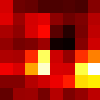

In [ ]:
from netdissect import imgviz
iv = imgviz.ImageVisualizer(100)
iv.heatmap(acts[0,1], mode='nearest')

If you tell IV to dereference the activations for you, it scales heatmaps according to global statistics.

What is happening with unit 418?

Each unit has a different scale, which makes the heatmaps harder to interpret.

We can normalize the scales by collecting stats.


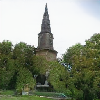
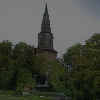
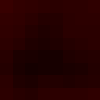
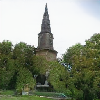
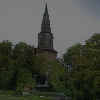
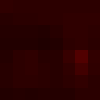
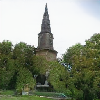
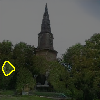
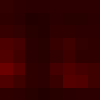
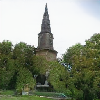
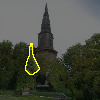
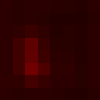
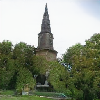
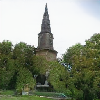
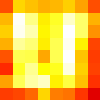
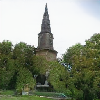
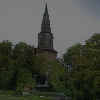
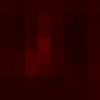

In [ ]:
show(
    [['unit %d' % u,
      [iv.image(img[0])],
      [iv.masked_image(img[0], acts, (0,u))],
      [iv.heatmap(acts, (0,u), mode='nearest')],
     ] for u in range(414, 420)]
)

## Collecting quantile statistics for every unit

We want to know per-channel minimum or maximum values, means, medians, quantiles, etc.

We want to treat each pixel as its own sample for all the channels.  For example, here are the activations for one image as an 8x8 tensor over with 512 channels.  We can disregard the geometry and just look at it as a 64x512 sample matrix, that is 64 samples of 512-dimensional vectors.

In [ ]:
print(acts.shape)
print(acts.permute(0, 2, 3, 1).contiguous().view(-1, acts.shape[1]).shape)

torch.Size([1, 512, 8, 8])
torch.Size([64, 512])


Net dissection has a tally package that tracks quantiles over large samples.

To use it, just define a function that returns sample matrices like the 64x512 above, and then it will call your function on every batch and tally up the statistics.

In [ ]:
from netdissect import tally

# To collect stats, define a function that returns 2d [samples, units]
def compute_samples(zbatch):
    print('\n', len(zbatch), zbatch.shape)
    _ = model(zbatch.to(device))          # run the model
    acts = model.retained_layer('layer4') # get the activations, and flatten
    print('\n acts.shape =', acts.permute(0, 2, 3, 1).contiguous().view(-1, acts.shape[1]).shape)
    return acts.permute(0, 2, 3, 1).contiguous().view(-1, acts.shape[1])

# Then tally_quantile will run your function over the whole dataset to collect quantile stats
rq = tally.tally_quantile(compute_samples, zds)

# Print out the median value for the first 20 channels
rq.quantiles(0.5)[:20]

  0%|          | 0/5 [00:00<?, ?it/s]


 10 torch.Size([10, 512, 1, 1])


 20%|##        | 1/5 [00:04<00:17,  4.41s/it]


 acts.shape = torch.Size([640, 512])

 10 torch.Size([10, 512, 1, 1])


 40%|####      | 2/5 [00:07<00:11,  3.90s/it]


 acts.shape = torch.Size([640, 512])

 10 torch.Size([10, 512, 1, 1])


 60%|######    | 3/5 [00:11<00:07,  3.76s/it]


 acts.shape = torch.Size([640, 512])

 10 torch.Size([10, 512, 1, 1])


 80%|########  | 4/5 [00:15<00:03,  3.67s/it]


 acts.shape = torch.Size([640, 512])

 10 torch.Size([10, 512, 1, 1])



 acts.shape = torch.Size([640, 512])


tensor([-0.4046, -0.5428, -0.3631,  2.9844, -0.2847, -0.5570, -0.6854, -0.8811,
        -0.3581, -0.7223, -1.1460, -0.5441, -0.8785, -0.5749, -0.9384, -0.8077,
        -0.0543, -0.7799, -0.6179, -0.5356])

In [ ]:
model(zds[0][0][None,...].to(device))

In [ ]:
torch.tensor(3).dtype

torch.int64

## Exploring quantiles

The rq object tracks a sketch of all the quantiles of the sampled data.  For example, what is the mean, median, and percentile value for each unit?

In [ ]:
# This tells me now, for example, what the means are for channel,
# rq.mean()
# what median is,
# rq.quantiles(0.5)
# Or what the 99th percentile quantile is.
# rq.quantiles(0.99)

(rq.quantiles(0.8) > 0).sum()

tensor(294)

The quantiles can be plugged directly into the ImageVisualizer to put heatmaps on an informative per-unit scale.  When you do this:

   * Heatmaps are shown on a scale from black to white from 1% lowest to the 99% highest value.
   * Masked image lassos are shown at a 95% percentile level (by default, can be changed).
   
Now unit 418 doesn't drown out the other ones in the visualization.


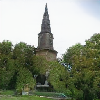
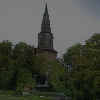
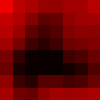
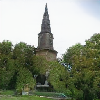
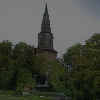
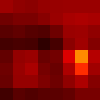
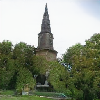
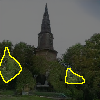
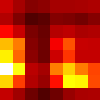
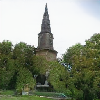
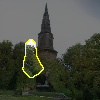
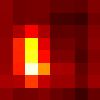
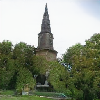
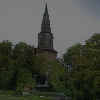
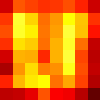
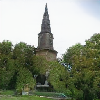
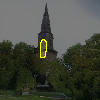
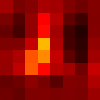

In [ ]:
# WHEN IT SAYS UNIT HERE IT'S REFERRING TO THE CHANNEL, HENCE WHY WE GET AN 8x8 TENSOR PER UNIT
# The heatmap is then shaded given how active each node is given the stats on its respective channel
# the 8x8 tensors clearly represent the image in some way

iv = imgviz.ImageVisualizer(100, quantiles=rq)
show([
    [  # for every unit, make a block containing
       'unit %d' % u,         # the unit number
       [iv.image(img[0])],    # the unmodified image
       [iv.masked_image(img[0], acts, (0,u))], # the masked image
       [iv.heatmap(acts, (0,u), mode='nearest')], # the heatmap
    ]
    for u in range(414, 420)
])

## Visualizing top-activating images

A useful way to visualize units is to sort a sample, in order of highest activation.  tally_topk does this.

Like torch.topk, it returns both the top k values and the top k indexes.  But instead of acting on a single tensor, it iterates over the whole data set.

In [ ]:
def compute_image_max(zbatch):
    image_batch = model(zbatch.to(device))
    return model.retained_layer('layer4').max(3)[0].max(2)[0]

topk = tally.tally_topk(compute_image_max, zds)
topk.result()[1].shape

torch.Size([512, 50])


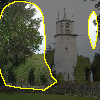
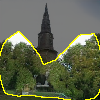
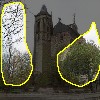
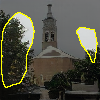
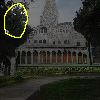
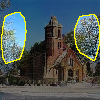
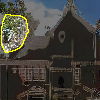
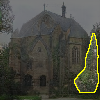

In [ ]:
# For each unit, this function prints out unit masks from the top-activating images
def unit_viz_row(unitnum, percent_level=0.95):
    out = []
    for imgnum in topk.result()[1][unitnum][:8]:
        img = model(zds[imgnum][0][None,...].to(device))
        acts = model.retained_layer('layer4')
        out.append([imgnum.item(),
                    # [iv.image(img[0])],
                    [iv.masked_image(img[0], acts, (0, unitnum), percent_level=percent_level)],
                    # [iv.heatmap(acts, (0, unitnum), mode='nearest')],
                   ])
    return out

show(unit_viz_row(365))

# Exercise 2 - Evaluate matches with semantic concepts

Do the filters match any semantic concepts?  To systematically examine this question,
we have pretrained (using lots of labeled data) a semantic segmentation network to recognize
a few hundred classes of objects, parts, and textures.

Run the code in this section to look for matches between filters in our GAN and semantic
segmentation clases.

## Labeling semantics within the generated images

Let's quantify what's inside these images by segmenting them.

First, we create a segmenter network.  (We use the Unified Perceptual Parsing segmenter by Xiao, et al. (https://arxiv.org/abs/1807.10221).

Note that the segmenter we use here requires a GPU.

If you have a CPU only, you can skip to step "Examining units that select for trees" below.

In [ ]:
# from netdissect import segmenter, setting

# # segmodel = segmenter.UnifiedParsingSegmenter(segsizes=[256])
# segmodel, seglabels, _ = setting.load_segmenter('netpq')
# # seglabels = [l for l, c in segmodel.get_label_and_category_names()[0]]
# print('segmenter has', len(seglabels), 'labels')

Then we create segmentation images for the dataset.  Here tally_cat just concatenates batches of image (or segmentation) data.

  * `segmodel.segment_batch` segments an image
  * `iv.segmentation(seg)` creates a solid-color visualization of a segmentation
  * `iv.segment_key(seg, segmodel)` makes a small legend for the segmentation

In [ ]:
# from netdissect import upsample
# from netdissect import segviz

# imgs = tally.tally_cat(lambda zbatch: model(zbatch.to(device)), zds)
# seg = tally.tally_cat(lambda img: segmodel.segment_batch(img.cuda(), downsample=1), imgs)

# from netdissect.segviz import seg_as_image, segment_key
# show([
#     (iv.image(imgs[i]),
#      iv.segmentation(seg[i,0]),
#      iv.segment_key(seg[i,0], segmodel)
#     )
#     for i in range(min(len(seg), 5))
# ])

## Identifying units that correlate with visual concepts

Some units align well with visual concepts.

To identify these, we will collect *conditional* activation statistics.

In addition to regular quantile statistics, we will collect quantile statistics over all the subsets of pixels in which a particular visual concept is present.

To do this, we will use the `tally_conditional_quantile` loop.

It expects its `compute` function to return a list of sample statistics, each one keyed by a condition that is present.

Here is how we do it.

In [ ]:
# # We upsample activations to measure them at each segmentation location.
# upfn8 = upsample.upsampler((64, 64), (8, 8)) # layer4 is resolution 8x8

# def compute_conditional_samples(zbatch):
#     image_batch = model(zbatch.to(device))
#     seg = segmodel.segment_batch(image_batch, downsample=4)
#     upsampled_acts = upfn8(model.retained_layer('layer4'))
#     return tally.conditional_samples(upsampled_acts, seg)

# # Run this function once to sample one image
# sample = compute_conditional_samples(zds[0][0].cuda()[None,...])

# # The result is a list of all the conditional subsamples
# [(seglabels[c], d.shape) for c, d in sample]

In [ ]:
# cq = tally.tally_conditional_quantile(compute_conditional_samples, zds)

Conditional quantile statistics let us compute lots of relationships between units and visual concepts.

For example, IoU is the "intersection over union" ratio, measuring how much overlap there is between the top few percent activations of a unit and the presence of a visual concept.  We can estimate the IoU ratio for all pairs between units and concepts with these stats:

In [ ]:
# iou_table = tally.iou_from_conditional_quantile(cq, cutoff=0.99)
# iou_table.shape

Now let's view a few of the units, labeled with an associated concept, sorted from highest to lowest IoU.

In [ ]:
# unit_list = sorted(enumerate(zip(*iou_table.max(1))), key=lambda k: -k[1][0])

# for unit, (iou, segc) in unit_list[:5]:
#     print('unit %d: %s (iou %.2f)' % (unit, seglabels[segc], iou))
#     show(unit_viz_row(unit))

We can quantify the overall match between units and segmentation concepts by counting the number of units that match a segmentation concept (omitting low-scoring matches).

In [ ]:
# print('Number of units total:', len(unit_list))
# print('Number of units that match a segmentation concept with IoU > 0.04:',
#    len([i for i in range(len(unit_list)) if unit_list[i][1][0] > 0.04]))

## Examining units that select for trees

Now let's filter just units that were labeled as 'tree' units.

In [ ]:
# tree_index = seglabels.index('tree')
# tree_units = [(unit, iou) for iou, unit in
#               list(zip(*(iou_table[:,tree_index].sort(descending=True))))[:10]]

In [ ]:
# tree_units = [(unit, iou, segc) for unit, (iou, segc) in unit_list if seglabels[segc] == 'tree'][:10]
# If you can't run the segmenter, uncomment the line below and comment the one above.
tree_units = [365, 157, 119, 374, 336, 195, 278, 76, 408, 125]

for unit in tree_units:
    print('unit %d' % unit)
    show(unit_viz_row(unit))

## Editing a model by altering units

Now let's try changing some units directly to see what they do.

We we will use `model.edit_layer` to do that.

This works by just allowing you to define a function that edits the output of a layer.

We will edit the output of `layer4` by zeroing ten of the tree units.

In [ ]:
def zero_out_tree_units(data, model):
    data[:, tree_units, :, :] = 0.0
    return data

imgs = tally.tally_cat(lambda zbatch: model(zbatch.to(device)), zds)
model.edit_layer('layer4', rule=zero_out_tree_units)
edited_imgs = tally.tally_cat(lambda zbatch: model(zbatch.to(device)), zds)
# removed the before bit here because it didn't work
show([
    (['Before', [renormalize.as_image(imgs[i])]],
     ['After', [renormalize.as_image(edited_imgs[i])]])
      for i in range(10)])
model.remove_edits()

# Exercise 3 - Testing causal effects of representation units

Now it's your turn.

Now try the following experiments:
   * Instead of zeroing the tree units, try setting them negative, e.g., to -5.
   * Instead of turning the tree units off, try turning them on, e.g., set them to 10.


In [ ]:
# model.edit_layer('layer4')
# edited_imgs = tally.tally_cat(lambda zbatch: model(zbatch.to(device)), zds)
# show([
#     (['Before', [renormalize.as_image(imgs[i])]],
#      ['After', [renormalize.as_image(edited_imgs[i])]])
#       for i in range(min(10, len(zds)))])
# model.remove_edits()

In [ ]:
# Solution to exercise 1.

def turn_off_tree_units(data, model):
    data[:, tree_units, :, :] = -5.0
    return data

model.edit_layer('layer4', rule=turn_off_tree_units)
edited_imgs = tally.tally_cat(lambda zbatch: model(zbatch.to(device)), zds)
show([
    (['Before', [renormalize.as_image(imgs[i])]],
     ['After', [renormalize.as_image(edited_imgs[i])]])
      for i in range(min(10, len(zds)))])
model.remove_edits()


def strengthen_tree_units(data, model):
    data[:, tree_units, :, :] = 10.0
    return data

model.edit_layer('layer4', rule=strengthen_tree_units)
edited_imgs = tally.tally_cat(lambda zbatch: model(zbatch.to(device)), zds)
show([
    (['Before', [renormalize.as_image(imgs[i])]],
     ['After', [renormalize.as_image(edited_imgs[i])]])
      for i in range(min(10, len(zds)))])
model.remove_edits()

# Exercise 4 - Examining units for other concepts


Find a set of `door`-selective units `door_units` (instead of `tree_units`), or choose another concepts such as `grass` or `dome`.

Then create a set of examples show the effect of setting the these off, to `-5.0` or on, at `10.0`.

What is the effect on doors?  What is the effect on other types of objects in the generated scenes?

In [ ]:
# Solution to exercise 2.

door_index = seglabels.index('door')
door_units = [(unit, iou) for iou, unit in
              list(zip(*(iou_table[:,door_index].sort(descending=True))))[:10]]

def turn_off_door_units(data, model):
    data[:, door_units, :, :] = -5.0
    return data

model.edit_layer('layer4', rule=turn_off_door_units)
edited_imgs = tally.tally_cat(lambda zbatch: model(zbatch.to(device)), zds)
show([
    (['Before', [renormalize.as_image(imgs[i])]],
     ['After', [renormalize.as_image(edited_imgs[i])]])
      for i in range(min(10, len(zds)))])
model.remove_edits()

# Exercise 5 - Comparing layers

Collect and visualize the maximum activating images for each unit in `layer5` or `layer6`.

Count units that match segmented concepts with IoU > 0.04 in your layer.

Are there more matching units than `layer4`, or fewer?

Hints:
* To examine the representation at layer5, you will need to `model.retain_layer('layer5')`
* layer5 has resolution 16x16 and needs a new upfn function to upsample from that resolution. layer2 is 4x4.
* Get conditional quantiles using `tally_conditional_quantile` with a compute_conditional_samples written for layer5.
* Then use `iou_from_conditional_quantile` to count matches between units and concepts.



In [ ]:
# Solution for exercise 3
model.retain_layer('layer5')

upfn16 = upsample.upsampler((64, 64), (16, 16)) # layer5 is resolution 16x16

def compute_layer5_conditional_samples(zbatch):
    image_batch = model(zbatch.to(device))
    seg = segmodel.segment_batch(image_batch, downsample=4)
    upsampled_acts = upfn16(model.retained_layer('layer5'))
    return tally.conditional_samples(upsampled_acts, seg)

cq5 = tally.tally_conditional_quantile(compute_layer5_conditional_samples, zds)

iou_table5 = tally.iou_from_conditional_quantile(cq5, cutoff=0.99)



In [ ]:
unit_list5 = sorted(enumerate(zip(*iou_table5.max(1))), key=lambda k: -k[1][0])
print('Number of units matching concepts:',
      len([i for i in range(len(unit_list5)) if unit_list5[i][1][0] > 0.04]))

# Layer5 has 227 matching units, even more!

In [ ]:
# Visualizations of units at layer5 can be done like this
def unit_viz_row5(unitnum, percent_level=0.95):
    out = []
    for imgnum in topk5.result()[1][unitnum][:8]:
        img = model(zds[imgnum][0][None,...].to(device))
        acts = model.retained_layer('layer5')
        out.append([imgnum.item(),
                    # [iv.image(img[0])],
                    [iv.masked_image(img[0], acts, (0, unitnum), percent_level=percent_level)],
                    # [iv.heatmap(acts, (0, unitnum), mode='nearest')],
                   ])
    return out

def compute_image_max5(zbatch):
    image_batch = model(zbatch.to(device))
    return model.retained_layer('layer5').max(3)[0].max(2)[0]

topk5 = tally.tally_topk(compute_image_max5, zds)

for unit, (iou, segc) in unit_list5[:20]:
    print('unit %d: %s (iou %.2f)' % (unit, seglabels[segc], iou))
    show(unit_viz_row5(unit))


# Extra exercises - Comparing networks

Different types of convolutional networks such as image classifiers can be dissected.

The main difference is that the segmented concepts are based on input images rather than generated images.

To see dissection on a classifier, see the notebook at:
[This link](https://colab.research.google.com/github/SIDN-IAP/global-model-repr/blob/master/notebooks/netdissect_exercise.ipynb)

One last visualization summarizes dissection - just showing masks and units side-by-side for a few examples

In [ ]:
iv2 = imgviz.ImageVisualizer(256, quantiles=rq)
model.remove_edits()
def compute_acts(zbatch):
    model(zbatch.to(device))
    return model.retained_layer('layer4')

acts = tally.tally_cat(compute_acts, zds).cpu()
unit = 365
segc = 4

if True:
    show([
        (iv2.image(imgs[i]),
         iv2.segmentation(seg[i,0], 4),
         iv2.heatmap(acts, (i, unit), mode='nearest'),
         iv2.masked_image(imgs[i], acts, (i, unit))
        )
        for i in [0,2,4,9,25,28]
    ])

if False:
    show([
        (iv2.image(imgs[i]),
         iv2.segmentation(seg[i,0], 4),
         iv2.heatmap(acts, (i, unit), mode='nearest'),
         iv2.masked_image(imgs[i], acts, (i, unit))
        )
        for i in [1,5,7,8,10,11]
    ])

if False:
    show([
        (iv2.image(imgs[i]),
         iv2.segmentation(seg[i,0], 11),
         iv2.heatmap(acts, (i, 149), mode='nearest'),
         iv2.masked_image(imgs[i], acts, (i, 149))
        )
        for i in [0,2,4,9,25,28]
    ])

Special thanks to Lucy Chai, Àgata Lapedriza, and Katherine Gallagher for testing this notebook.